In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn
import seaborn as sns 

import utils
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn import metrics 
from scipy.spatial import distance


In [5]:
subjs = utils.ExpInfo.getSubjIDs()
# subj = utils.ExpInfo.getSubjIDs()[0]
task = utils.ExpInfo.taskName[1]


In [31]:
def get_traj_hidden_dist(subj, task):
    xhy = utils.LoadData.xhy(subj, task)
    xhy_disp = utils.LoadData.xhy_disp(subj, task)
    df_beh = utils.LoadData.behaviorData(subj, task) 

    dist_measure = 'euclidean'
    dists = []
    dist_coss = []
    roc_auc = []
    prediction = []
    for iTrial in range(len(xhy[1])):
        dist_cos = []
        dist = []
        for iDot in range(3):
            h1 = xhy[1][iTrial][:-1, :]
            h2 = xhy_disp[1][iTrial][iDot]
            dist_cos_ = cosine_similarity(h1, h2).diagonal()
            dist_ = paired_distances(h1, h2, metric=dist_measure)
            dist_cos.append(dist_cos_)
            dist.append(dist_)
            
        dist = np.vstack(dist).T
        dist_cos = np.vstack(dist_cos).T 
        
        # predict choise
        prediction.append(np.argmin(dist.mean(axis=0)) + 1)
        
        dists.append(dist)
        dist_coss.append(dist_cos)
        
        # ROC
        y_true = np.zeros(dist.shape)
        target = df_beh['target dot'][iTrial]-1
        y_true[:, target] = 1
        # fpr, tpr, thresholds = metrics.roc_curve(y_true.flatten(), 1-dist.flatten())
        fpr, tpr, thresholds = metrics.roc_curve(y_true.flatten(), 1-dist.flatten())
        roc_auc.append(metrics.auc(fpr, tpr))
        
    df_beh_ = df_beh.copy()
    df_beh_['AUC'] = roc_auc
    df_beh_['prediction'] = prediction
    
    return df_beh_

df = utils.GroupOperation.map(get_traj_hidden_dist, subjs, task)

|████████████████████████████████████████| 50/50 [100%] in 35.5s (1.41/s)                                                16s) 


In [32]:
df = pd.concat(df, axis=0)

# AUC

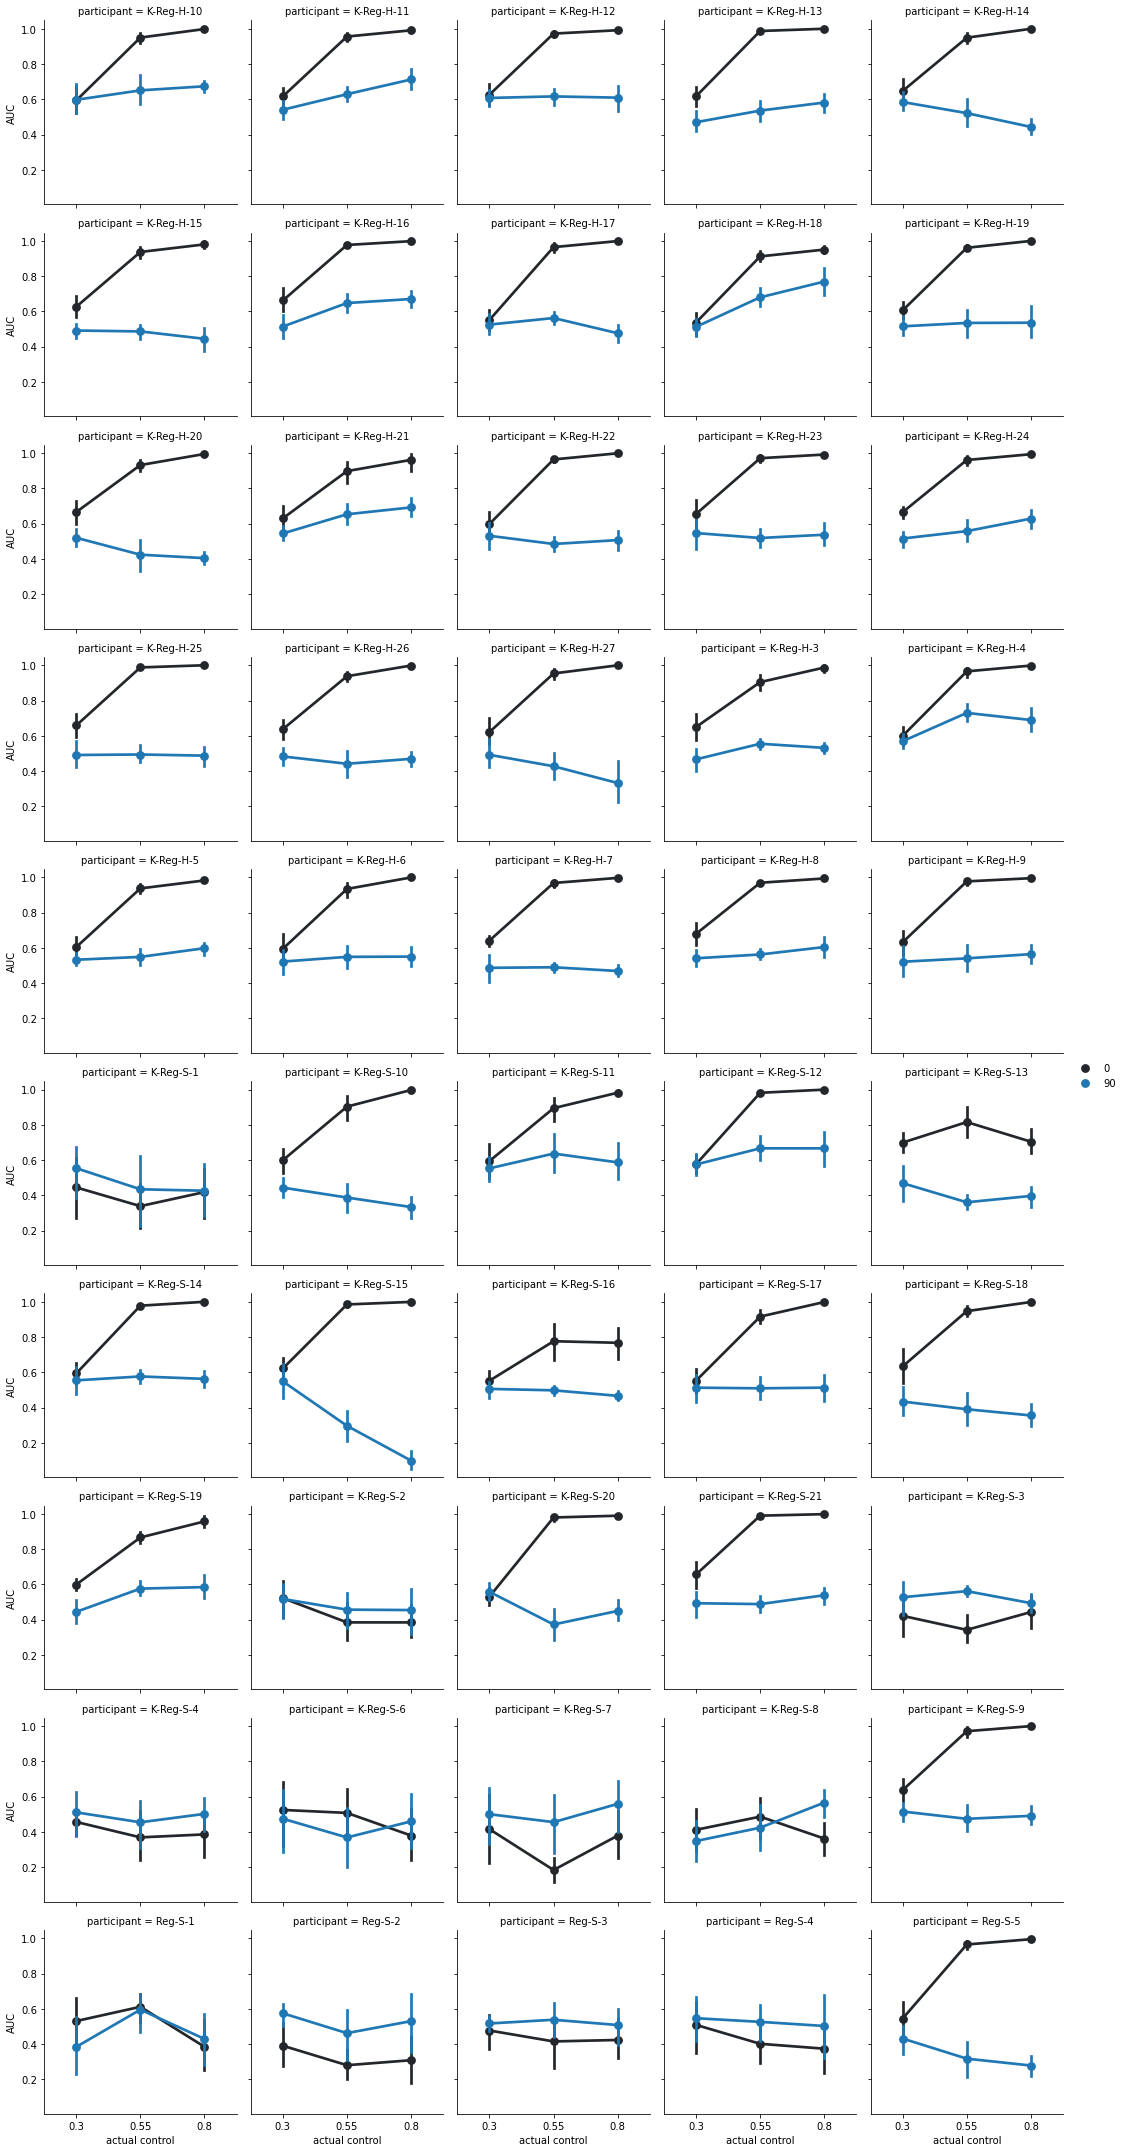

In [33]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='AUC', 
                   hue='angular bias')
grid.add_legend()

# Predict choise from distance

In [34]:
df_ = df.copy()
df_['pred_accuracy'] = df_['prediction'] == df_['selected dot']
df_['pred_accuracy_target'] = df_['prediction'] == df_['target dot']

df_ = df_[['participant', 'actual control', 'angular bias', 'pred_accuracy']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias']).mean()
df_ = df_.reset_index()

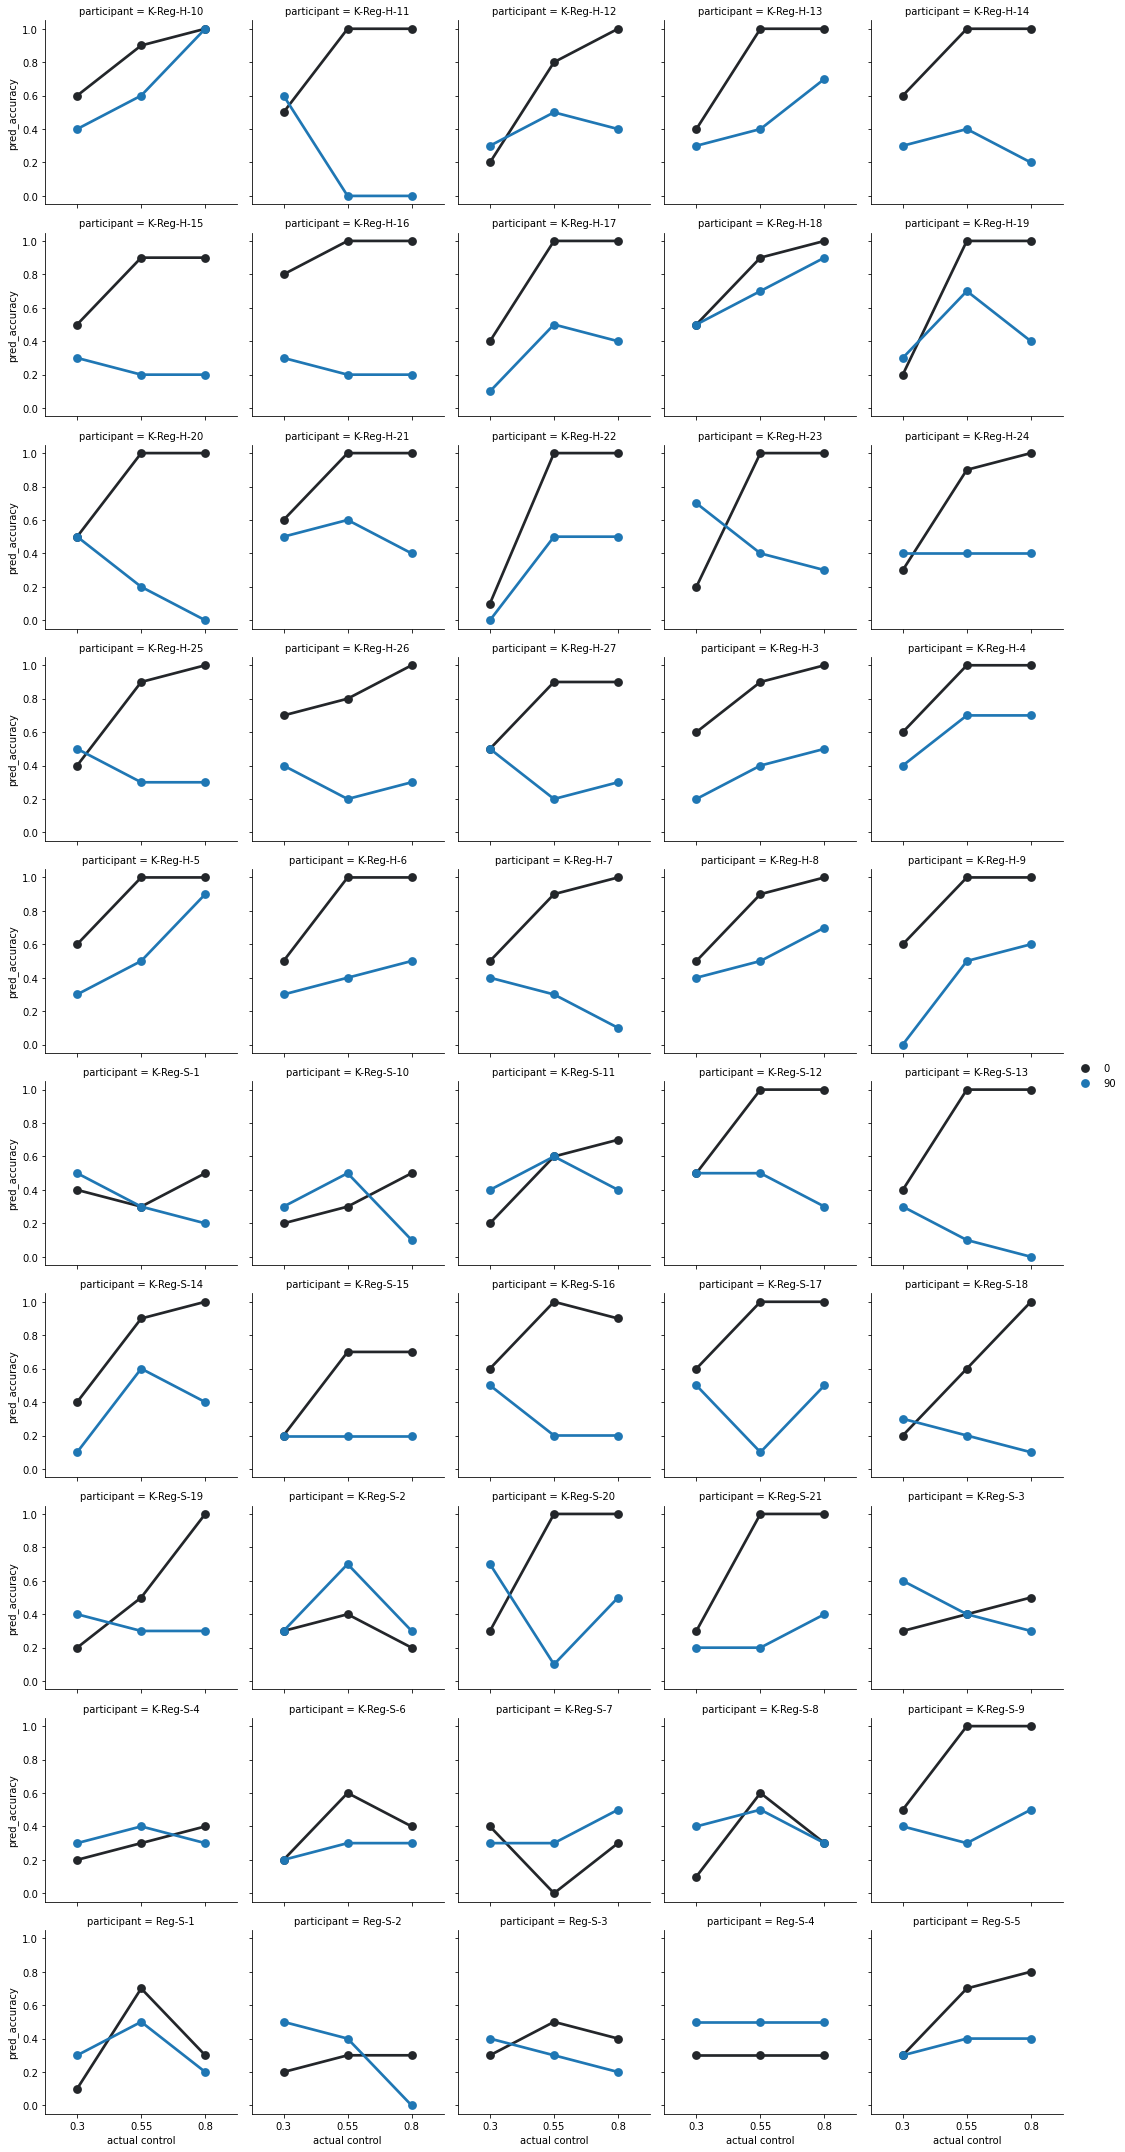

In [35]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='pred_accuracy', 
                   hue='angular bias')
grid.add_legend()

# Predict target from distance

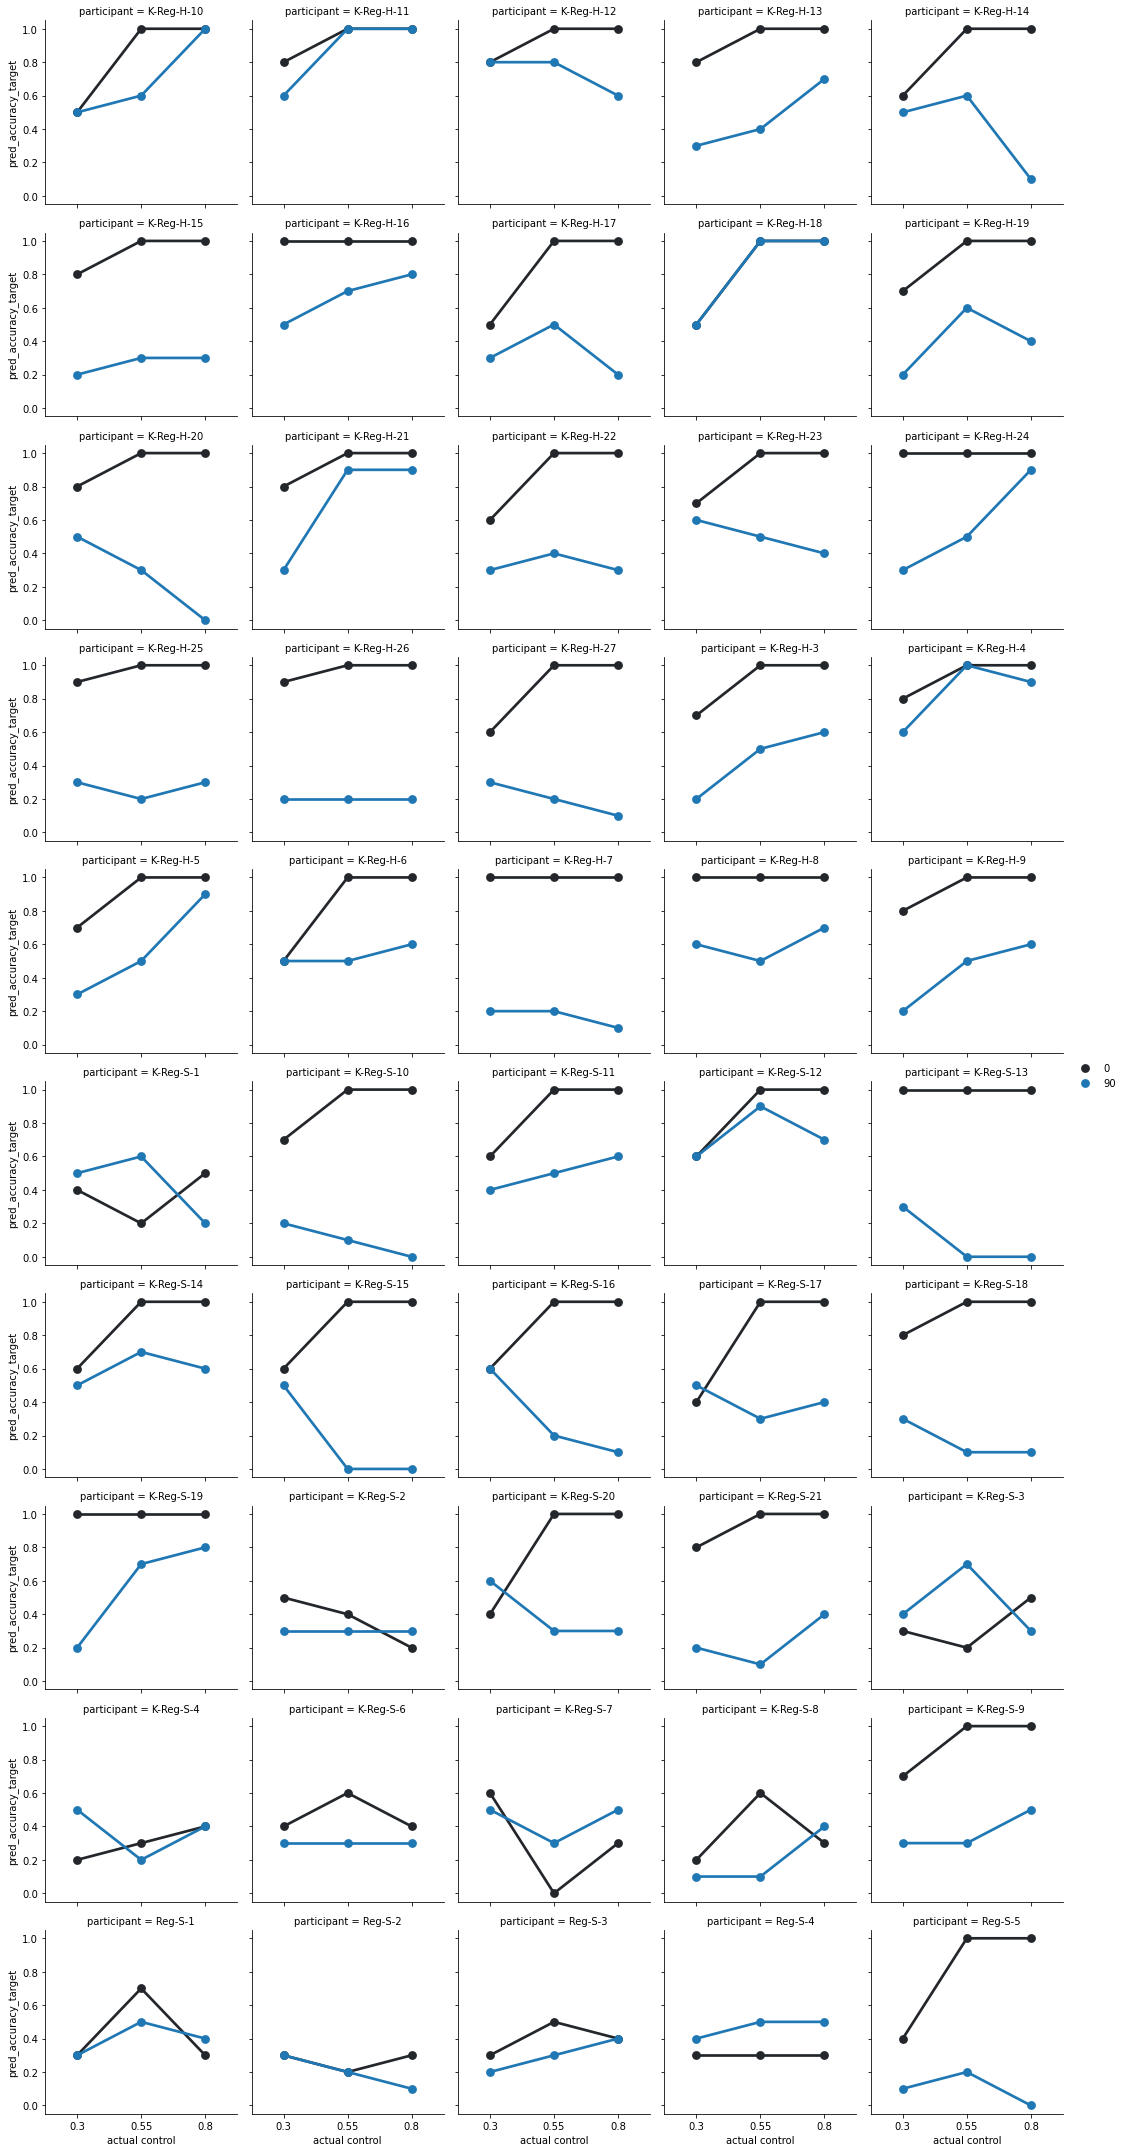

In [36]:
df_ = df.copy()
df_['pred_accuracy'] = df_['prediction'] == df_['selected dot']
df_['pred_accuracy_target'] = df_['prediction'] == df_['target dot']

df_ = df_[['participant', 'actual control', 'angular bias', 'pred_accuracy_target', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias','group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='pred_accuracy_target', 
                   hue='angular bias')
grid.add_legend()

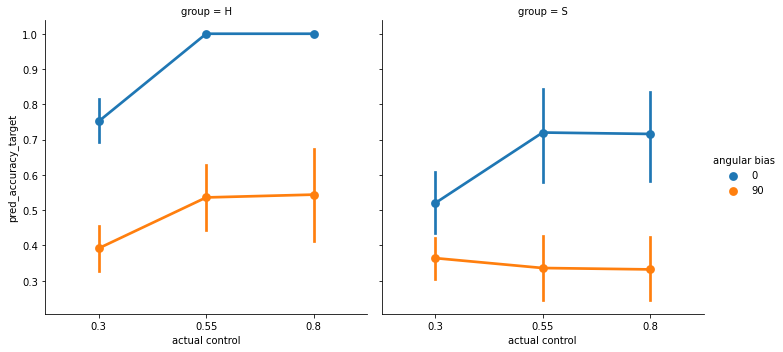

In [37]:
sns.catplot(x='actual control', y='pred_accuracy_target', hue='angular bias', data=df_, col='group', kind='point')
